In [2]:
import pandas as pd
pd.set_option('max_colwidth', 80)

from re import sub, split
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, MDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, word_tokenize

import sklearn
import re
import string
from string import punctuation
from collections import Counter

from wordcloud import WordCloud 
import matplotlib.pyplot as plt

import spacy

#### Plot function 

In [3]:
def plot_embedding(V, y):
    """ Visualizes a vocabulary embedding via TSNE """
    V = TruncatedSVD(50).fit_transform(V)
    d = TSNE(metric='cosine').fit_transform(V)
    d = pd.DataFrame(d).assign(label = y.reset_index(drop=True))
    return sns.scatterplot(x = 0, y = 1, hue = 'label', data = d), d

#### Preprocessing functions  

In [40]:
# helper function to clean tweets
spLem_en = spacy.load('en')

emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)


def clean_twitter(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    # Convert @username 
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    # Remove colon symbol 
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    # Remove \n
    tweet = sub("\n", " ", tweet) 
    # Replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    # Remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
    # Remove additional spaces
    tweet = sub(' +', ' ',tweet) 
    # Lemmatize
    tweet = spLem_en(tweet)
    tweet = " ".join([token.lemma_ for token in tweet])
    
    return tweet

In [41]:
# Tokenize
def text_process(tweet):

    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(tweet) if char not in string.punctuation]
    # Join the characters again to form the string
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.lower().split() if word not in stopwords.words('english') and word not in stopwords.words('french')]       

# Remove additional words 
def remove_words(tweet):
    
    remove = ['rt','https','...','“','”','’','…','the', 'of', 'on', 'a', 'is', 'and', 'https...', '000', 'pron']
    tweet = [w for w in tweet if w not in remove]
    
    return tweet

# Stemmatization 
def stemmatize(tweet):
    
    porter = PorterStemmer()
    return [porter.stem(word) for word in tweet]

#### A quick look at the data 

In [42]:
X = pd.read_csv('/Users/lucgerits/Desktop/Trimester 3/14D010  Text Mining for Social Sciences/text-mining-master/data/tweets.csv').tweet
y = pd.read_csv('/Users/lucgerits/Desktop/Trimester 3/14D010  Text Mining for Social Sciences/text-mining-master/data/tweets.csv').label
data = pd.read_csv('/Users/lucgerits/Desktop/Trimester 3/14D010  Text Mining for Social Sciences/text-mining-master/data/tweets.csv')

data.head(5)

,tweet,label
0,RT @LilMissRightie: Here's CNN on Sharia law. You can be stoned or have your...,y2016
1,RT @NetworksManager: LOOK obama Clinton cronies ILLEGALLY arm &amp; train mu...,y2016
2,RT @GrrrGraphics: #ThrowbackThursday #BenGarrison #cartoon from 2013 #Obama ...,y2016
3,"RT @PeterTownsend7: Say 'Islam is peace', or else! #trump #maga #isis #tcot...",y2016
4,RT @ToddDracula: @realDonaldTrump All aboard the Trump Train! #ChooChoo 🚂 ht...,y2016


In [23]:
# Check the number of tweets by year (label)
lab16 = data['label'][data.label == "y2016"]
lab17 = data['label'][data.label == "y2017"]
lab18 = data['label'][data.label == "y2018"]

print('number of 2016 tweets is:  {}'.format(len(lab16)))
print('number of 2017 tweets is: {}'.format(len(lab17)))
print('number of 2018 tweets is: {}'.format(len(lab18)))
print('total length of the data is:            {}'.format(data.shape[0]))

number of 2016 tweets is:  750
number of 2017 tweets is: 750
number of 2018 tweets is: 750
total length of the data is:            2250


In [24]:
# Get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
data['word count'] = data['tweet'].apply(word_count)

data.head(5)

,tweet,label,word count
0,RT @LilMissRightie: Here's CNN on Sharia law. You can be stoned or have your...,y2016,26
1,RT @NetworksManager: LOOK obama Clinton cronies ILLEGALLY arm &amp; train mu...,y2016,20
2,RT @GrrrGraphics: #ThrowbackThursday #BenGarrison #cartoon from 2013 #Obama ...,y2016,15
3,"RT @PeterTownsend7: Say 'Islam is peace', or else! #trump #maga #isis #tcot...",y2016,14
4,RT @ToddDracula: @realDonaldTrump All aboard the Trump Train! #ChooChoo 🚂 ht...,y2016,11


In [25]:
# Get the most common words
all_words = []
for line in list(data['tweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
Counter(all_words).most_common(10)

[('rt', 1784),
 ('the', 700),
 ('to', 480),
 ('on', 409),
 ('in', 389),
 ('of', 388),
 ('a', 332),
 ('is', 290),
 ('and', 268),
 ('@saminfidel:', 233)]

#### Apply preprocessing functions

In [43]:
data = data.copy()

# clean the tweet column
data['tweet_clean'] = data['tweet'].apply(clean_twitter)

# tokenize the tweet column, remove other words, and create a column for each transformation 
data['tokens'] = data['tweet_clean'].apply(text_process) 
data['tokens_2'] = data['tokens'].apply(remove_words) 
data['tokens_3'] = data['tokens_2'].apply(stemmatize) 

data.head(10)

,tweet,label,tweet_clean,tokens,tokens_2,tokens_3
0,RT @LilMissRightie: Here's CNN on Sharia law. You can be stoned or have your...,y2016,here cnn sharia law -PRON- can stone have -PRON- hand cut off but but there ...,"[cnn, sharia, law, pron, stone, pron, hand, cut, https]","[cnn, sharia, law, stone, hand, cut]","[cnn, sharia, law, stone, hand, cut]"
1,RT @NetworksManager: LOOK obama Clinton cronies ILLEGALLY arm &amp; train mu...,y2016,look obama clinton crony illegally arm train muslim terrorist include isis s...,"[look, obama, clinton, crony, illegally, arm, train, muslim, terrorist, incl...","[look, obama, clinton, crony, illegally, arm, train, muslim, terrorist, incl...","[look, obama, clinton, croni, illeg, arm, train, muslim, terrorist, includ, ..."
2,RT @GrrrGraphics: #ThrowbackThursday #BenGarrison #cartoon from 2013 #Obama ...,y2016,from 2013 get crown,"[2013, get, crown]","[2013, get, crown]","[2013, get, crown]"
3,"RT @PeterTownsend7: Say 'Islam is peace', or else! #trump #maga #isis #tcot...",y2016,say islam peace else,"[say, islam, peace, else]","[say, islam, peace, else]","[say, islam, peac, els]"
4,RT @ToddDracula: @realDonaldTrump All aboard the Trump Train! #ChooChoo 🚂 ht...,y2016,all aboard the trump train,"[aboard, trump, train]","[aboard, trump, train]","[aboard, trump, train]"
5,RT @JudicialWatch: FLASHBACK &gt;&gt; Judicial Watch Releases Huma Abedin De...,y2016,flashback judicial watch release huma abedin deposition testimony,"[flashback, judicial, watch, release, huma, abedin, deposition, testimony]","[flashback, judicial, watch, release, huma, abedin, deposition, testimony]","[flashback, judici, watch, releas, huma, abedin, deposit, testimoni]"
6,"RT @LouDobbs: Following FBI presser, @realDonaldTrump says “the system is ri...",y2016,follow fbi presser say the system rig weigh 7 p.m.,"[follow, fbi, presser, say, system, rig, weigh, 7, pm]","[follow, fbi, presser, say, system, rig, weigh, 7, pm]","[follow, fbi, presser, say, system, rig, weigh, 7, pm]"
7,"RT @Ricky_Vaughn99: Trump: ""We're Running Against a Rigged Press"" https://t....",y2016,trump run against rigged press,"[trump, run, rigged, press]","[trump, run, rigged, press]","[trump, run, rig, press]"
8,RT @mitchellvii: Literally 98% of Hillary supporters I see online are astrot...,y2016,literally hillary supporter see online be astroturfe spammer with 000 commen...,"[literally, hillary, supporter, see, online, astroturfe, spammer, 000, comme...","[literally, hillary, supporter, see, online, astroturfe, spammer, comment, 1...","[liter, hillari, support, see, onlin, astroturf, spammer, comment, 100, follow]"
9,RT @ClarkW2016: @ConstantinCI @CathyTo47590555 \nIslam. ... https://t.co/8Fw...,y2016,islam,[islam],[islam],[islam]


In [44]:
map1 = data['tweet'].map(clean_twitter)
map1.head(5)

0    here cnn sharia law -PRON- can stone have -PRON- hand cut off but but there ...
1    look obama clinton crony illegally arm train muslim terrorist include isis s...
2                                                                from 2013 get crown
3                                                               say islam peace else
4                                                         all aboard the trump train
Name: tweet, dtype: object

In [45]:
map2 = data['tweet_clean'].map(text_process)
map2.head(5)

0                            [cnn, sharia, law, pron, stone, pron, hand, cut, https]
1    [look, obama, clinton, crony, illegally, arm, train, muslim, terrorist, incl...
2                                                                 [2013, get, crown]
3                                                          [say, islam, peace, else]
4                                                             [aboard, trump, train]
Name: tweet_clean, dtype: object

#### Visualization 

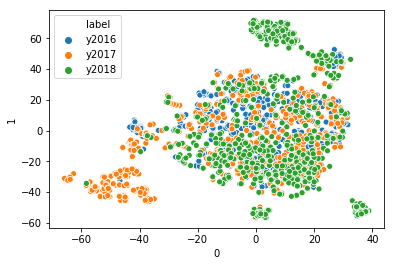

In [46]:
# Let's visualize our data by using nothing but the Sklearn default
# cleaning and tokenizing

vectorizer = CountVectorizer()
V = vectorizer.fit_transform(data['tweet'])
ax, d = plot_embedding(V, y)

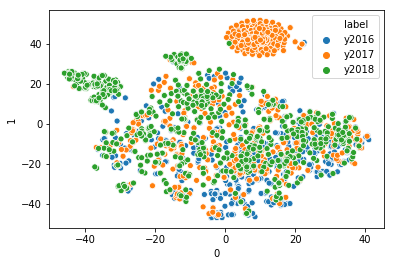

In [47]:
# Now let's see what our cleaning has done

vectorizer = CountVectorizer(preprocessor = clean_twitter)
V = vectorizer.fit_transform(data['tweet'])
ax, d = plot_embedding(V, y)

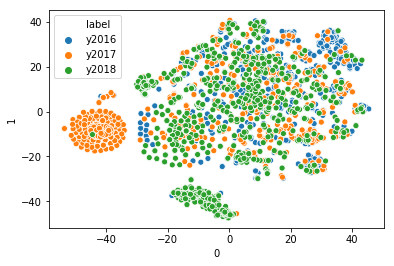

In [48]:
# Now try with TF-IDF vectorizer, and add implicit stopwords! <-- don't know what this means 
#(is this about the words i removed myself above?)
# Can you get things to separate in the space in a better way? 

vectorizer = TfidfVectorizer(preprocessor = clean_twitter)
V = vectorizer.fit_transform(data['tweet'])
ax, d = plot_embedding(V, y)

#### WordCloud

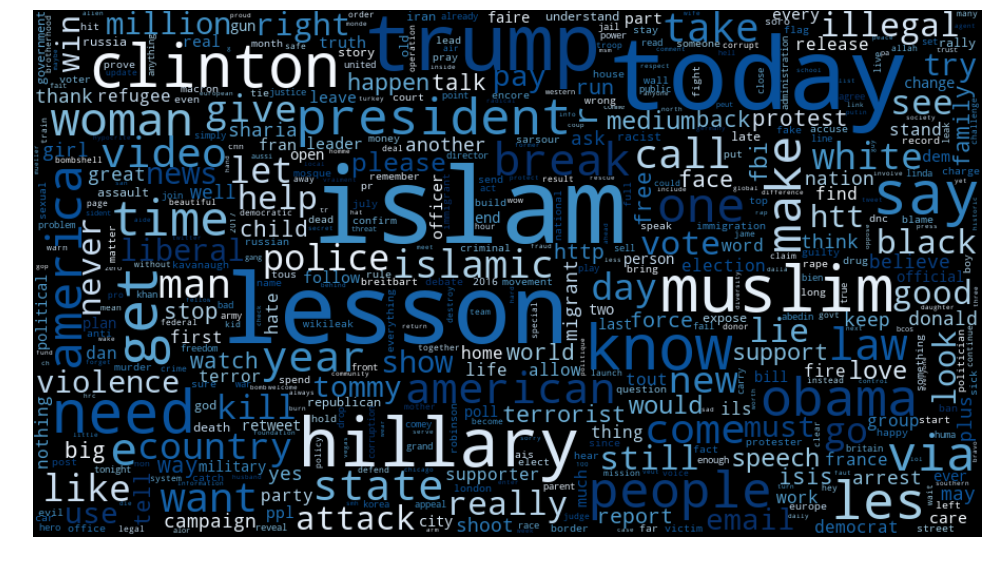

In [49]:
# Split tweets into individual words
all_words = []
for line in data['tokens_2']: 
    all_words.extend(line)
    
# Create a word frequency dictionary
wordfreq = Counter(all_words)

# Draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()